#### import packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, LeavePOut
from sklearn.feature_selection import RFE, SequentialFeatureSelector as SFS
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

from handytool.sklearn.metrics import safe_auc_score, specificity_score, eval_model, safe_roc_curve, Report
from handytool.sklearn.model_selection import StratifiedLeavePairOut

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
# 全局设置图形字体为 Arial
plt.rcParams['font.family'] = 'Arial'

#### import data & preprocessing

In [2]:
file_paths = {
    'PD': 'features_郊游风景图_v7.csv',
    'SN': 'features_三毛流浪记_v7.csv',
    'SR': 'features_牛郎织女_v7.csv'
}
# Previously extracted highly discriminative univariate features
univars = {
    'PD': ['PNP', 'PAP', 'cmpd', 'MDD'],
    'SN': ['C/S', 'C/T', 'PVP', 'MDN', 'prep', 'HF/W'],
    'SR': ['PAP', 'advmod', 'HF/W']
}

def load_data(task_type, feat_select_method = 'RFE', feature_set = 'all'):
    file_path = file_paths[task_type]
    selected_cols = univars[task_type]
    
    # Read csv
    df = pd.read_csv(file_path)
    
    # Normalization
    scaler = StandardScaler()
    scaler.fit(df[list(df.columns)[2:-1]])
    df[list(df.columns)[2:-1]] = scaler.transform(df[list(df.columns)[2:-1]])
    
    # Replace 'AD' and 'MCI' with 'CI'
    df['label'] = df['label'].replace(['AD', 'MCI'], 'CI')
    
    # Extract features and ground truth labels
    feats_all = df.drop(['date_subject', 'label'], axis=1)
    y = df['label']
    
    # Decide the range of features
    if feature_set == 'all':
        X_selected = feats_all
    if feature_set == 'sub':
        X_selected = feats_all[selected_cols]
    
    num_feats = X_selected.shape[1]
    
    return feats_all, X_selected, y, num_feats

In [3]:
# Load the dataset and initialization
task_type = 'SN' #设置，PD、SN、SR三选一
feat_select_method = 'EFS' # 设置，可选RFE、SFS、EFS。
                           # 
                           # 同样特征数量，不同方法选出来的也可能不同（路径依赖）
                           # SFS速度慢，只搭配下面的sub，且最好有监控
                           # 理想情况下EFS是最好的，速度慢
                           # 搭配sub可以用所有特征
                           # 搭配all仅用于验证特征数量为2是否为最佳特征组合
feature_set = 'sub' # 设置，all或sub
                    # all只能搭配RFE
cv_method = 'SLPO' # 本研究全部选定为SLPO，不用k-fold、LOO和简单LPO
                  # 不同交叉验证方法可能会得到结果不同
opt_targ = 'AUC_CV' # 设置，可选ACC、AUC_CV
    
feats_all, X, y, num_feats = load_data(task_type, feat_select_method, feature_set)
# if feat_select_method == 'EFS':
#     num_feats = 2

#### train the classifiers with recursive feature elimination

In [4]:
def feat_select(method, clf, feats, n_features_to_select):
    if method == 'RFE' or (method == 'SFS' and feats.shape[1] == n_features_to_select):
        selector = RFE(clf,
                       n_features_to_select=n_features_to_select)
    elif method == 'SFS':
        selector = SFS(clf, 
                       n_features_to_select=n_features_to_select, 
                       direction='forward',
                       #scoring='accuracy', 
                       scoring='roc_auc',  # 如果是LOO不能和AUC同时用！
                       #cv=LeaveOneOut(),
                       cv=slpo,
                       #cv=7 #交叉验证
                       n_jobs=-1) # 利用所有处理器核心
    elif method == 'EFS': #有可能会有多组特征结果相同，但他只会保留一组
        selector = EFS(clf, 
                  min_features=n_features_to_select,  # 最小特征数量
                  max_features=n_features_to_select,  # 最大特征数量（此处为2，因为只要2个特征的组合）
                  #scoring='accuracy',  # 使用准确率来评估模型
                  scoring='roc_auc',
                  print_progress=True,  # 显示进度，可打开
                  #cv=LeaveOneOut(),
                  cv=slpo,
                  n_jobs=-1) # 利用所有处理器核心
    selector.fit(feats, y)
    ###EFS测试用
    #metric_dict = selector.get_metric_dict() # test
    #best_auc = max(metric_dict, key=lambda x: metric_dict[x]['avg_score'])
    #print(f'Best AUC: {metric_dict[best_auc]["avg_score"]}')
    ###
    selected_feats = selector.transform(feats)
    if method in ['RFE', 'SFS']:
        selected_feat_indices = selector.get_support(indices=True)
    elif method == 'EFS':
        selected_feat_indices = list(selector.best_idx_)  # 这是被选中的特征索引
    selected_labels = [feats.columns[i] for i in selected_feat_indices]  # 获取特征名称
    return selected_feats, selected_labels

In [5]:
loo = LeaveOneOut()
# 设置 KFold，假设 k = 5
k = 49
kf = KFold(n_splits=k, shuffle=True, random_state=42)
#lpo = LeavePOut(p=2)
slpo = StratifiedLeavePairOut(positive_label='CI', negative_label='CN')
splitted_dataset = slpo.split(X, y)
num_of_cv = len(list(splitted_dataset))
print(f'number of CV loops: {num_of_cv}')

def train_predict(X, y, feat_labels, model):
    X_selected = X[feat_labels].to_numpy() # 选择特征并转换为 NumPy 数组
    model.fit(X_selected, y) # 拟合模型
    y_pred = model.predict(X_selected) # 一次性预测所有样本
    prob = model.predict_proba(X_selected)[:, 1]  # 获取正类的概率
    return y_pred, prob

def eval_model_cv(X, y, model, cv_method = cv_method):
    # 预测模型
    # 输入：特征、黄金标准、分类器、交叉验证方法
    # 输出：平均ACC和平均AUC
    if cv_method == 'SLPO':
        accs = []
        aucs = []
        #precs = []
        recs = []
        f1s = []
        specs = []
        splitted_dataset = slpo.split(X, y)
        for train_index, test_index in splitted_dataset:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            y_true = y_test
            y_pred = model.predict(X_test)
            prob = model.predict_proba(X_test)[:, 1]
            accs.append(accuracy_score(y_true, y_pred))
            aucs.append(roc_auc_score(y_true == 'CI', prob))
            #precs.append(precision_score(y_true, y_pred, pos_label='CI'))
            recs.append(recall_score(y_true, y_pred, pos_label='CI'))
            f1s.append(f1_score(y_true, y_pred, pos_label='CI'))
            specs.append(specificity_score(y_true, y_pred, pos_label='CI', neg_label='CN'))
        acc_mean = np.mean(accs)
        auc_mean = np.mean(aucs)
        #prec_mean = np.mean(precs)
        rec_mean = np.mean(recs)
        f1_mean = np.mean(f1s)
        spec_mean = np.mean(specs)
        if auc_mean < 0.5:
            auc_mean = 1 - auc_mean
        #report = Report(acc_mean, prec_mean, rec_mean, f1_mean, spec_mean, auc_mean)
        report = Report(acc_mean, None, rec_mean, f1_mean, spec_mean, auc_mean)
        return report
    elif cv_method == 'LOO':
        y_true = []
        y_pred = []
        prob = []
        splitted_dataset = loo.split(X)
        for train_index, test_index in splitted_dataset:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            y_pred.append(model.predict(X_test))
            y_true.append(y_test)
            prob.append(model.predict_proba(X_test)[:, 1])
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        acc_mean = accuracy_score(y_true, y_pred)
        # 这里不对，LOO中平均AUC是无法计算的。要么就是使用Prob来算
        auc_mean = safe_auc_score(y_true == 'CI', prob)
    elif cv_method == 'KF': #暂时不用，未测试
        y_true = []
        y_pred = []
        prob = []
        splitted_dataset = kf.split(X)
        for train_index, test_index in splitted_dataset:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            # 下面三行一定要写extend而不是append！适用于k折交叉验证的情况
            y_pred.extend(model.predict(X_test))
            y_true.extend(y_test)
            prob.extend(1 - model.predict_proba(X_test)[:, 1])
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        acc_mean = accuracy_score(y_true, y_pred)
        auc_mean = safe_auc_score(y_true == 'CI', prob)
    
    return acc_mean, auc_mean

number of CV loops: 600


#### find the best number of features

In [6]:
# 准备ACC随特征数N变化的数据，基于LPO循环交叉验证
# 初始化嵌套字典，用于储存数据
results = {
    'LR': {},
    'SVM': {},
    'LDA': {}
}
best_results = {
    'LR': {'max_metric': 0, 'best_i': 1},
    'SVM': {'max_metric': 0, 'best_i': 1},
    'LDA': {'max_metric': 0, 'best_i': 1}
}
# 初始化矩阵：每行表示n，每列表示模型
df_acc = pd.DataFrame(columns=['LR', 'SVM', 'LDA'])
df_auc_cv = pd.DataFrame(columns=['LR', 'SVM', 'LDA'])
df_auc_self = pd.DataFrame(columns=['LR', 'SVM', 'LDA'])

models = {
    'LR': LogisticRegression(random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'LDA': LinearDiscriminantAnalysis()
}

# 存储每个模型的表现
acc_values = {}
auc_cv_values = {}
auc_self_values = {}

for i in range(1, num_feats+1):
    for model_name, estimator in models.items():
        # 特征选择
        X_selected, selected_labels = feat_select(feat_select_method, estimator, X, n_features_to_select=i)
        print(f'特征数：{i}, 模型：{model_name}, 选择特征：{selected_labels}')
        
        # 交叉验证评估模型性能
        #acc_mean, auc_mean = eval_model_cv(X_selected, y, estimator, cv_method)
        report = eval_model_cv(X_selected, y, estimator, cv_method)
        #results[model_name][i] = {'ACC': acc_mean, 'AUC_CV': auc_mean, 'feat_selected': X_selected, 'lab_selected': selected_labels}
        results[model_name][i] = {'ACC': report.acc_, 'AUC_CV': report.auc_, 'feat_selected': X_selected, 'lab_selected': selected_labels, 'report': report}
        
        # 保存每个模型的评估结果
        #acc_values[model_name] = acc_mean
        #auc_cv_values[model_name] = auc_mean
        acc_values[model_name] = report.acc_
        auc_cv_values[model_name] = report.auc_
        print(report.acc_)
        print(report.auc_)
        
        # 自评
        # 记录每个模型的评估结果
        y_pred = []
        prob = []
        estimator.fit(X_selected, y)  # 模型拟合
        for j in range(len(y)):
            y_pred.append(estimator.predict([X_selected[j]]))
            prob.append(1 - estimator.predict_proba([X_selected[j]])[:, 1])  # 概率值
        # AUC自评估
        y_true = y
        results[model_name][i]['AUC_self'] = safe_auc_score(y_true == 'CI', prob)
        auc_self_values[model_name] = results[model_name][i]['AUC_self']
        results[model_name][i]['coef'] = estimator.coef_ if hasattr(estimator, 'coef_') else None  # 处理有些模型可能没有 coef_
        
        # 保存最佳结果
        if results[model_name][i][opt_targ] > best_results[model_name]['max_metric']:
            best_results[model_name] = {
                'best_i': i,
                'max_metric': results[model_name][i][opt_targ]
            }
    # 更新 df_acc, df_auc_cv, df_auc_self
    df_acc.loc[i] = [acc_values['LR'], acc_values['SVM'], acc_values['LDA']]
    df_auc_cv.loc[i] = [auc_cv_values['LR'], auc_cv_values['SVM'], auc_cv_values['LDA']]
    df_auc_self.loc[i] = [auc_self_values['LR'], auc_self_values['SVM'], auc_self_values['LDA']]

Features: 6/6

特征数：1, 模型：LR, 选择特征：['MDN']
0.6866666666666666
0.8049999999999999


Features: 6/6

特征数：1, 模型：SVM, 选择特征：['MDN']
0.6766666666666666
0.8049999999999999


Features: 6/6

特征数：1, 模型：LDA, 选择特征：['MDN']
0.6858333333333333
0.8049999999999999


Features: 15/15

特征数：2, 模型：LR, 选择特征：['MDN', 'prep']
0.84
0.8666666666666667


Features: 15/15

特征数：2, 模型：SVM, 选择特征：['MDN', 'prep']
0.8475
0.8683333333333334


Features: 15/15

特征数：2, 模型：LDA, 选择特征：['MDN', 'prep']
0.8225
0.865


Features: 20/20

特征数：3, 模型：LR, 选择特征：['C/S', 'MDN', 'prep']
0.825
0.8616666666666667


Features: 20/20

特征数：3, 模型：SVM, 选择特征：['C/T', 'MDN', 'prep']
0.8375
0.8666666666666667


Features: 20/20

特征数：3, 模型：LDA, 选择特征：['C/T', 'MDN', 'prep']
0.82
0.8583333333333334


Features: 15/15

特征数：4, 模型：LR, 选择特征：['C/S', 'PVP', 'MDN', 'prep']
0.8175
0.8516666666666667


Features: 15/15

特征数：4, 模型：SVM, 选择特征：['C/T', 'PVP', 'MDN', 'prep']
0.8225
0.865


Features: 15/15

特征数：4, 模型：LDA, 选择特征：['C/S', 'C/T', 'MDN', 'prep']
0.8341666666666666
0.8533333333333333


Features: 6/6

特征数：5, 模型：LR, 选择特征：['C/S', 'C/T', 'PVP', 'MDN', 'prep']
0.8358333333333333
0.85


Features: 6/6

特征数：5, 模型：SVM, 选择特征：['C/S', 'C/T', 'PVP', 'MDN', 'prep']
0.8283333333333334
0.8583333333333334


Features: 6/6

特征数：5, 模型：LDA, 选择特征：['C/S', 'C/T', 'MDN', 'prep', 'HF/W']
0.8183333333333334
0.85


Features: 1/1

特征数：6, 模型：LR, 选择特征：['C/S', 'C/T', 'PVP', 'MDN', 'prep', 'HF/W']
0.8008333333333333
0.8316666666666667


Features: 1/1

特征数：6, 模型：SVM, 选择特征：['C/S', 'C/T', 'PVP', 'MDN', 'prep', 'HF/W']
0.7808333333333334
0.84


Features: 1/1

特征数：6, 模型：LDA, 选择特征：['C/S', 'C/T', 'PVP', 'MDN', 'prep', 'HF/W']
0.7958333333333333
0.8316666666666667


SN-EFS-sub-SLPO
Logistic Regression:
Number of features selected: 2
Features selected: ['MDN', 'prep']
Weight: [[1.11873758 0.83116263]]
Best AUC_CV: 86.67%
Mean ACC: 84.00%
Mean REC: 84.50%
Mean SPEC: 76.75%
Mean F1: 79.67%
AUC-self: 86.67%
Support Vector Machine:
Number of features selected: 2
Features selected: ['MDN', 'prep']
Weight: [[1.5555175  0.91068878]]
Best AUC_CV: 86.83%
Mean ACC: 84.75%
Mean REC: 85.67%
Mean SPEC: 77.58%
Mean F1: 80.89%
AUC-self: 86.83%
Linear Discriminant Analysis:
Number of features selected: 2
Features selected: ['MDN', 'prep']
Weight: [[1.04745401 0.94225359]]
Best AUC_CV: 86.50%
Mean ACC: 82.25%
Mean REC: 79.83%
Mean SPEC: 75.67%
Mean F1: 75.44%
AUC-self: 87.00%


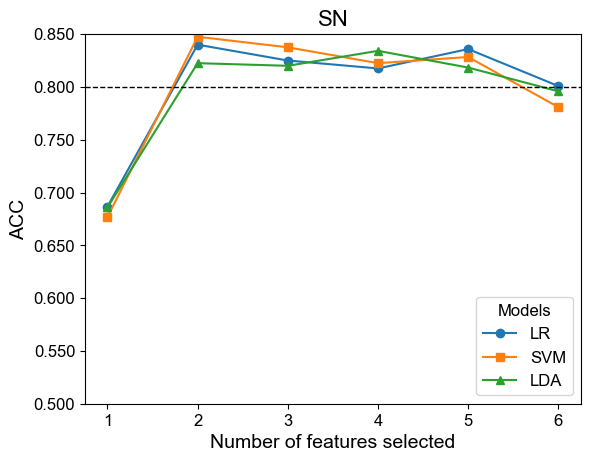

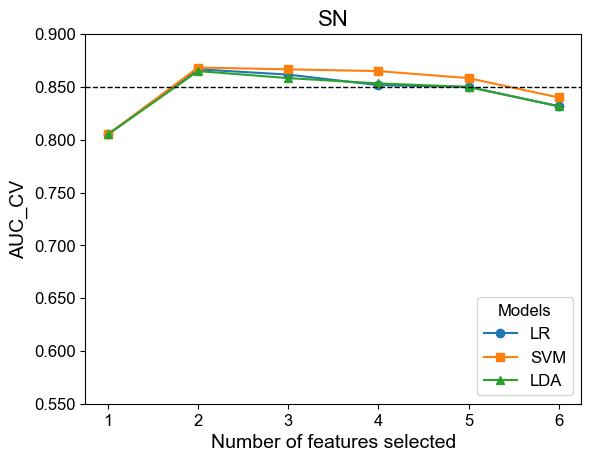

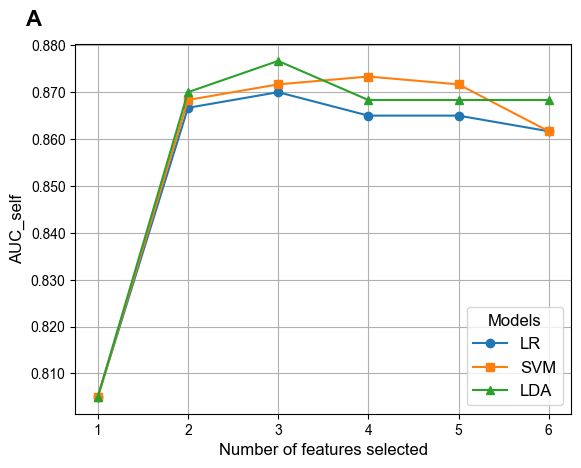

In [7]:
# 输出最优number of features下优化目标的结果
print(f'{task_type}-{feat_select_method}-{feature_set}-{cv_method}')
# Logistic Regression
best_number = best_results['LR']['best_i']
X_selected = results["LR"][best_number]["feat_selected"]
selected_labels = results["LR"][best_number]["lab_selected"]
n_features_to_select = len(selected_labels)
weight = results["LR"][best_number]["coef"]
metric = results["LR"][best_number][opt_targ]
mean_acc = results['LR'][best_number]['ACC']
print("Logistic Regression:")
print(f'Number of features selected: {n_features_to_select}')
print(f'Features selected: {selected_labels}')
print(f'Weight: {weight}')
print(f'Best {opt_targ}: {metric*100:.2f}%')
print(f'Mean ACC: {mean_acc*100:.2f}%')
print(f"Mean REC: {results['LR'][best_number]['report'].rec_*100:.2f}%")
print(f"Mean SPEC: {results['LR'][best_number]['report'].spec_*100:.2f}%")
print(f"Mean F1: {results['LR'][best_number]['report'].f1_*100:.2f}%")
print(f"AUC-self: {results['LR'][best_number]['AUC_self']*100:.2f}%")

# Support Vector Machine
best_number = best_results['SVM']['best_i']
X_selected = results["SVM"][best_number]["feat_selected"]
selected_labels = results["SVM"][best_number]["lab_selected"]
n_features_to_select = len(selected_labels)
weight = results["SVM"][best_number]["coef"]
metric = results["SVM"][best_number][opt_targ]
mean_acc = results['SVM'][best_number]['ACC']
print("Support Vector Machine:")
print(f'Number of features selected: {n_features_to_select}')
print(f'Features selected: {selected_labels}')
print(f'Weight: {weight}')
print(f'Best {opt_targ}: {metric*100:.2f}%')
print(f'Mean ACC: {mean_acc*100:.2f}%')
print(f"Mean REC: {results['SVM'][best_number]['report'].rec_*100:.2f}%")
print(f"Mean SPEC: {results['SVM'][best_number]['report'].spec_*100:.2f}%")
print(f"Mean F1: {results['SVM'][best_number]['report'].f1_*100:.2f}%")
print(f"AUC-self: {results['SVM'][best_number]['AUC_self']*100:.2f}%")

# Linear Discriminant Analysis
best_number = best_results['LDA']['best_i']
X_selected = results["LDA"][best_number]["feat_selected"]
selected_labels = results["LDA"][best_number]["lab_selected"]
n_features_to_select = len(selected_labels)
weight = results["LDA"][best_number]["coef"]
metric = results["LDA"][best_number][opt_targ]
mean_acc = results['LDA'][best_number]['ACC']
print("Linear Discriminant Analysis:")
print(f'Number of features selected: {n_features_to_select}')
print(f'Features selected: {selected_labels}')
print(f'Weight: {weight}')
print(f'Best {opt_targ}: {metric*100:.2f}%')
print(f'Mean ACC: {mean_acc*100:.2f}%')
print(f"Mean REC: {results['LDA'][best_number]['report'].rec_*100:.2f}%")
print(f"Mean SPEC: {results['LDA'][best_number]['report'].spec_*100:.2f}%")
print(f"Mean F1: {results['LDA'][best_number]['report'].f1_*100:.2f}%")
print(f"AUC-self: {results['LDA'][best_number]['AUC_self']*100:.2f}%")

# 绘制ACC-N折线图
# 使用 matplotlib 绘制折线图
plt.figure(figsize=(6.4, 4.8)) # 设置图形大小
plt.plot(np.arange(1, num_feats+1), df_acc["LR"], label="LR", marker="o")  # LR
plt.plot(np.arange(1, num_feats+1), df_acc["SVM"], label="SVM", marker="s")  # SVM
plt.plot(np.arange(1, num_feats+1), df_acc["LDA"], label="LDA", marker="^")  # LDA
plt.axhline(y=0.8, color='black', linestyle='--', linewidth=1)
plt.xlabel("Number of features selected", fontsize=14) # 添加行标题
plt.ylabel("ACC", fontsize=14) # 添加列标题
#plt.xlim(left=0)  
plt.ylim(top=0.85, bottom=0.5)
#plt.xticks(np.arange(1, num_feats+1, step=1), fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f')) # 使用 FormatStrFormatter 设置 Y 轴刻度保留三位小数
plt.legend(title="Models", loc="lower right", fontsize=12, title_fontsize=12) # 添加图例
#plt.grid(True) # 显示网格
#plt.text(-0.1, 1.05, 'A', fontsize=18, fontweight='bold', fontname='Arial', transform=plt.gca().transAxes) # 在左上角添加子图序号
plt.title(task_type, fontsize=16)
plt.savefig(f"ACC-N-{task_type}-{feature_set}.svg", format="svg", bbox_inches='tight') # 保存图片为 SVG 格式
plt.show()# 显示图形

# 绘制AUC_CV-N折线图
# 使用 matplotlib 绘制折线图
plt.figure(figsize=(6.4, 4.8)) # 设置图形大小
plt.plot(np.arange(1, num_feats+1), df_auc_cv["LR"], label="LR", marker="o")  # LR
plt.plot(np.arange(1, num_feats+1), df_auc_cv["SVM"], label="SVM", marker="s")  # SVM
plt.plot(np.arange(1, num_feats+1), df_auc_cv["LDA"], label="LDA", marker="^")  # LDA
plt.axhline(y=0.85, color='black', linestyle='--', linewidth=1)
plt.xlabel("Number of features selected", fontsize=14) # 添加行标题
plt.ylabel("AUC_CV", fontsize=14) # 添加列标题
#plt.xlim(left=0)
y_min = df_auc_cv.min().min()  # 获取y轴数据中的最小值
plt.ylim(top=0.9, bottom=y_min - (y_min * 0.05))  # 给最小值留出5%的空间
plt.ylim(top=0.9, bottom=0.55)
#plt.xticks(np.arange(1, num_feats+1, step=1), fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f')) # 使用 FormatStrFormatter 设置 Y 轴刻度保留三位小数
plt.legend(title="Models", loc="lower right", fontsize=12, title_fontsize=12) # 添加图例
#plt.grid(True) # 显示网格
#plt.text(-0.1, 1.05, 'A', fontsize=16, fontweight='bold', fontname='Arial', transform=plt.gca().transAxes) # 在左上角添加子图序号
plt.title(task_type, fontsize=16)
plt.savefig(f"AUC_CV-N-{task_type}-{feature_set}.svg", format="svg", bbox_inches='tight') # 保存图片为 SVG 格式
plt.show()# 显示图形

# 绘制AUC_self-N折线图
# 使用 matplotlib 绘制折线图
plt.figure(figsize=(6.4, 4.8)) # 设置图形大小
plt.plot(np.arange(1, num_feats+1), df_auc_self["LR"], label="LR", marker="o")  # LR
plt.plot(np.arange(1, num_feats+1), df_auc_self["SVM"], label="SVM", marker="s")  # SVM
plt.plot(np.arange(1, num_feats+1), df_auc_self["LDA"], label="LDA", marker="^")  # LDA
plt.xlabel("Number of features selected", fontsize=12) # 添加行标题
plt.ylabel("AUC_self", fontsize=12) # 添加列标题
plt.xticks(np.arange(1, num_feats+1)) # 设置 x 轴刻度为整数
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f')) # 使用 FormatStrFormatter 设置 Y 轴刻度保留三位小数
plt.legend(title="Models", loc="lower right", fontsize=12, title_fontsize=12) # 添加图例
plt.grid(True) # 显示网格
plt.text(-0.1, 1.05, 'A', fontsize=16, fontweight='bold', fontname='Arial', transform=plt.gca().transAxes) # 在左上角添加子图序号
#plt.savefig("ACC_self-N.svg", format="svg", bbox_inches='tight') # 保存图片为 SVG 格式
plt.show()# 显示图形

['MDN', 'prep']


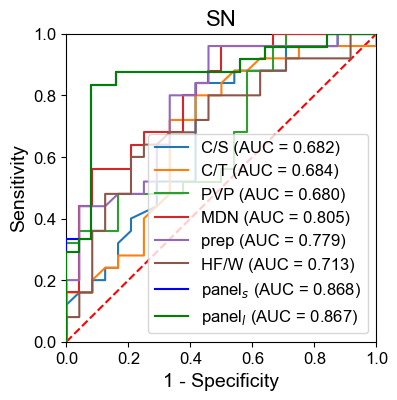

In [11]:
#考察单独的模型，画ROC曲线
plt.figure(figsize=(4, 4))
feat_labels = univars[task_type]
for feat in feat_labels:
    # 提取单列特征
    single_feat_values = feats_all[[feat]].to_numpy()  # 提取单列并转为NumPy数组
    fpr, tpr, thresholds = safe_roc_curve(y == "CI", single_feat_values)
    auc_value = safe_auc_score(y != 'CI', single_feat_values)

    # 绘制 ROC 曲线
    plt.plot(fpr, tpr, label=f'{feat} (AUC = {auc_value:.3f})', zorder=5)

if task_type == 'PD':
    model_1 = LinearDiscriminantAnalysis()
    feat_labels_m1 = ['cmpd', 'MDD']
    #12特征LDA
    model_2 = LinearDiscriminantAnalysis()
    feat_labels_m2 = ['S/W', 'T/W', 'C/S', 'MLS', 'MLC', 'MLT', 'PVP', 'MDN', 'advmod', 'prep', 'MDD', 'HF/W']
    #6特征 +SVM
    model_2 = SVC(kernel='linear', probability=True, random_state=42)
    feat_labels_m2 = ['PNP', 'PAdvP', 'PPP', 'advmod', 'nsubj', 'MDD']
    print(results['SVM'][6]['AUC_self'])
elif task_type == 'SN':
    model_1 = SVC(kernel='linear', probability=True, random_state=42)
    feat_labels_m1 = ['MDN', 'prep']
    #10特征+SVM
    #model_2 = SVC(kernel='linear', probability=True, random_state=42)
    #feat_labels_m2 = ['T/W', 'T/S', 'VP/T', 'PNP', 'PVP', 'PAdvP', 'advmod', 'cmpd', 'MDD', 'HF/W']
    #2特征+LR
    model_2 = LogisticRegression(random_state=42)
    feat_labels_m2 = ['MDN', 'prep']
elif task_type == 'SR':
    model_1 = SVC(kernel='linear', probability=True, random_state=42)
    feat_labels_m1 = ['PAP', 'advmod', 'HF/W']
    #13特征+SVM，SR
    model_2 = SVC(kernel='linear', probability=True, random_state=42)
    feat_labels_m2 = ['RP/W', 'MLS', 'MLC', 'PVP', 'PAP', 'PPP', 'MDN', 'advmod', 'nmod', 'nsubj', 'prep', 'MDD', 'HF/W']
#feat_labels_m1 = results["SVM"][best_number]["lab_selected"]
print(feat_labels_m1)
y_pred_m1, prob_m1 = train_predict(feats_all, y, feat_labels_m1, model_1)
fpr_m1, tpr_m1, thresholds_m1 = roc_curve(y != "CI", prob_m1)
auc_m1 = safe_auc_score(y == 'CI', prob_m1)

#selected_labels = results["SVM"][best_number]["lab_selected"]

y_pred_m2, prob_m2 = train_predict(feats_all, y, feat_labels_m2, model_2)
fpr_m2, tpr_m2, thresholds_m2 = roc_curve(y != "CI", prob_m2)
auc_m2 = safe_auc_score(y == 'CI', prob_m2)

plt.plot(fpr_m1, tpr_m1, color='blue', label='panel$_s$ (AUC = {:.3f})'.format(auc_m1), zorder=5)
plt.plot(fpr_m2, tpr_m2, color='green', label='panel$_l$ (AUC = {:.3f})'.format(auc_m2), zorder=5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
#plt.xlabel('False Positive Rate')
plt.xlabel('1 - Specificity', fontsize=14)
#plt.ylabel('True Positive Rate')
plt.ylabel('Sensitivity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(task_type, fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.savefig(f"ROC-{task_type}.svg", format="svg", bbox_inches='tight') # 保存图片为 SVG 格式
plt.show()

In [9]:
# # 绘制prob和composite_feature对列的散点图
# plt.figure(figsize=(8, 6))
# plt.scatter(composite_feats, prob, alpha=0.7, edgecolors='b', label='Composite vs Probability')
# # 添加图形标题和标签
# plt.title('Scatter Plot of Composite Features vs Predicted Probabilities', fontsize=14)
# plt.xlabel('Composite Features', fontsize=12)
# plt.ylabel('Predicted Probabilities', fontsize=12)
# # 显示网格和图例
# plt.grid(True)
# plt.legend()
# # 显示图形
# plt.show()


# # 提取线性模型的系数 (coef_) 和偏置 (intercept_)
# coefficients = estimator.coef_  # 权重系数 beta
# intercept = estimator.intercept_  # 偏置 b
# composite_feats = X_selected.dot(coefficients.T) + intercept
# composite_feats = X_selected.dot(coefficients.T)
# new_auc = safe_auc_score(y == 'CI', composite_feats)
# print(f"AUC of composite feature: {new_auc}")




# 进行 1000 次 bootstrap
# n_iterations = 1000
# n_size = len(y)
# auc_scores = []
# for i in range(n_iterations):
#     # 从测试集中随机抽样
#     indices = np.random.randint(0, n_size, n_size)  # 有放回抽样
#     X_sample = X_selected[indices]
#     y_sample = y_true[indices]
#     # 预测样本的概率
#     y_probs = estimator.predict_proba(X_sample)[:, 1]  # 取正类的概率
#     auc = roc_auc_score(y_sample, y_probs)  # 计算 AUC
#     auc_scores.append(auc)
# # 计算 95% 置信区间
# auc_lower_bound = np.percentile(auc_scores, 2.5)
# auc_median = np.percentile(auc_scores, 50)
# auc_upper_bound = np.percentile(auc_scores, 97.5)
# print(f'Bootstrap AUC 95% Confidence Interval: [{auc_lower_bound:.4f}, {auc_median:.4f}, {auc_upper_bound:.4f}]')


# # 画箱线图
# # 创建一个DataFrame以便绘图
# plot_data = pd.DataFrame({
#     'group': y_true,
#     'feats': composite_feats.flatten()
# })
# # 设置图形大小
# plt.figure(figsize=(8, 6))
# # 绘制箱线图
# sns.boxplot(x='group', y='feats', data=plot_data, palette="Set2", showfliers=False)
# # 叠加散点图
# sns.stripplot(x='group', y='feats', data=plot_data, color='black', jitter=True, alpha=0.7)
# # 添加标题和标签
# plt.xlabel('Group', fontsize=12)
# plt.ylabel('Composite feats', fontsize=12)
# # 在左上角添加字母 "A"
# plt.text(-0.1, 1.05, 'A', fontsize=16, fontweight='bold', fontname='Arial', transform=plt.gca().transAxes)
# # 显示图形
# plt.show()

# # Plot confusion matrix
# plt.figure(figsize=(4, 3))
# preds = ['CI', 'CN']
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=preds, yticklabels=preds)
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.show()